> This is continuation of assignment written in [03-Classification.ipynb](./03-Classification.ipynb)



# 3. Titanic Dataset

Explore the titanic dataset and predict which passenger will survive

## Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Dataset

In [2]:
def load_titanic_dataset(path):
    csv_path = path
    return pd.read_csv(csv_path)

In [3]:
titanic_train = load_titanic_dataset("./datasets/titanic/train.csv")
titanic_test = load_titanic_dataset("./datasets/titanic/test.csv")

In [4]:
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Meaning of the attributes:**
1. **PassengerId:** unique identifier for each passenger
2. **Survived:** This is the target. 0 means passenger did not survived and 1 means passenger has survived
3. **PClass:** Passenger class. Either 1, 2 or 3
4. **Name, Sex and Age:** Pretty self explanatory
5. **SibSp:** Number of siblings and spouse onboard
6. **Parch:** Number of parents onboard
7. **Ticket:** Ticket Id
8. **Fare:** Fare price (in pounds)
9. **Cabin:** Passenger's Cabin number
10. **Embarked:** where the passenger embarked from

Setting `PassengerId` as the index column

In [6]:
titanic_train = titanic_train.set_index("PassengerId")
titanic_test = titanic_test.set_index("PassengerId")

In [7]:
titanic_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Let's get info to see how much data is missing:

In [8]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


Okay, so **Age**, **Cabin** and **Embarked** are sometimes null, especially **Cabin** has 77% null values. We will going to ignore the Cabin for now and focus on the rest. The **Age** attribute has 19% null values, so we need to decide what to do with them. Replacing with the median age seems reasonable. We could be bit smarter by predicting the age based on other columns (for example, median age is 37 in 1st class, 29 in 2nd class and 24 in 3rd class), but we'll keep things simple as just use the overall median age.

The **Name** and **Ticket** attribute might contain some value, but they will be trickier to convert into useful numbers that a model can consume. So for now we will ignore them.

Just calculating median age based on class, as discussed in above text

In [13]:
titanic_train[titanic_train["Pclass"]==1]["Age"].median()

37.0

In [14]:
titanic_train[titanic_train["Pclass"]==2]["Age"].median()

29.0

In [15]:
titanic_train[titanic_train["Pclass"]==3]["Age"].median()

24.0

Let's take look at numerical attributes

In [17]:
titanic_train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


- Only **38%** survived! That's close enough to 40%, so accuracy will be a reasonable metric to evaluate our model
- The mean **Fare** was 32.20 pounds, which does not seems expensive (but it was probably a lot of money back then).
- The mean **Age** was less than 30 year old. 

Let's check the target is indeed 0 or 1:

In [18]:
titanic_train["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

Now let's take quick look at all other categorical attributes:

In [19]:
titanic_train["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [20]:
titanic_train["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [21]:
titanic_train["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Embarked attribute tells us from where the passenger has Embarked:C=Cherbourg, Q=Queenstown, S=Southampton.

## PreProcessing

Now Let's build our processing pipeline, starting with pipeline for numerical attributes

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer # Imputer takes care of missing values
from sklearn.preprocessing import StandardScaler

num_pipline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

Now we can build pipeline for categorical attirbute

In [24]:
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("cat_encoder", OneHotEncoder(sparse_output=False))
])

Now Let's join numerical and categorical attribute

In [27]:
from sklearn.compose import ColumnTransformer

num_attributes = ["Age", "SibSp", "Parch", "Fare"]
cat_attributes = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
    ("num", num_pipline, num_attributes ),
    ("cat", cat_pipeline, cat_attributes)
])

Cool! Now we have nice preprocessing pipeline that takes raw data and outputs numerical input features that we can feed to any ML model we want.

In [28]:
X_train = preprocess_pipeline.fit_transform(titanic_train[num_attributes+cat_attributes])
X_train

array([[-0.56573646,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.66386103,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.1046374 ,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276197, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

Let's not forget to get Labels:

In [29]:
y_train = titanic_train["Survived"]

## Model Training

We are now ready to train our classifier. Let's start with `RandomForestClassifier`

In [30]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Great! Our model is trained, let's make predictions on test set:

In [33]:
X_test = preprocess_pipeline.transform(titanic_test[num_attributes+cat_attributes])
y_pred = forest_clf.predict(X_test)

And now we can just build a CSV file with these predictions and then upload it on kaggle.

### Preparing format for submission

In [ ]:
y_pred

In [42]:
y_pred = pd.DataFrame(y_pred, columns=["Survived"])
y_pred

,Survived
0,0
1,0
2,0
3,1
4,1
...,...
413,0
414,1
415,0
416,0


In [55]:
y_pred = y_pred.set_index(titanic_test.index)

In [57]:
y_pred.to_csv("03-Titanic_Submission.csv") # This will create csv file

But wait! We can do better . Why don't we use cross-validation to have an idea of how good our model is?

### Validating Model

In [34]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores

array([0.74444444, 0.79775281, 0.75280899, 0.80898876, 0.87640449,
       0.83146067, 0.83146067, 0.7752809 , 0.83146067, 0.84269663])

In [35]:
forest_scores.mean()

0.8092759051186016

Not Bad!

Let's try `SVC`:

In [36]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores

array([0.81111111, 0.85393258, 0.7752809 , 0.87640449, 0.83146067,
       0.79775281, 0.82022472, 0.78651685, 0.85393258, 0.84269663])

In [37]:
svm_scores.mean()

0.8249313358302123

Great! This model looks much better

But instead of just looking at the mean accuracy across the 10 cross-validation folds, let's plot all 10 scores for each model, along with a box plot highlighting the lower and upper quartiles, and "whiskers" showing the extent of the scores. Note that the `boxplot()` function detects outliers (called "fliers") and does not include them within the whiskers. Specifically, if the lower quartile is $Q_{1}$ and the upper quartile is $Q_{3}$, then interquartile rage $IQR = Q_{3} - Q_{1}$ (this is box's height) and any score lower than $Q_{1} - 1.5*IQR$ is a flier, and so any score greater than $Q_{3} + 1.5*IQR$

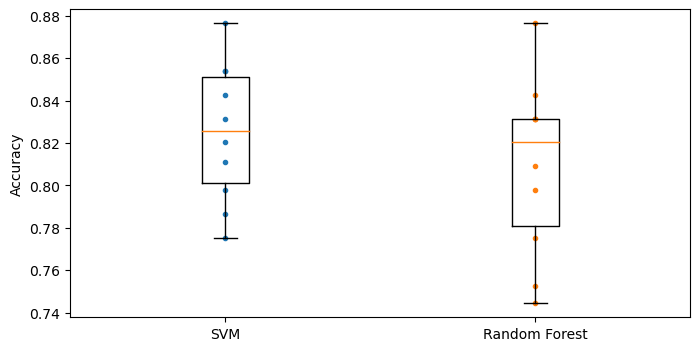

In [39]:
plt.figure(figsize=(8,4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM", "Random Forest"))
plt.ylabel("Accuracy")
plt.show()

The random forest classifier got a very high score on one of the 10 folds, but overall it had a lower mean score, as well as a bigger spread, so it looks like the SVM classifier is more likely to generalize well



To improve this result further, we could:

- Compare many more models and tune hyperparameters using cross validation and grid search,
- Do more feature engineering, for example:
    - Try to convert numerical attributes to categorical attributes: for example, different age groups had very different survival rates (see below), so it may help to create an age bucket category and use it instead of the age. Similarly, it may be useful to have a special category for people traveling alone since only 30% of them survived (see below).
    - Replace **SibSp** and **Parch** with their sum.
    - Try to identify parts of names that correlate well with the Survived attribute.
    - Use the **Cabin** column, for example take its first letter and treat it as a categorical attribute.



In [61]:
titanic_train["AgeBucket"] = titanic_train["Age"] // 15*15 
titanic_train[["AgeBucket", "Survived"]].groupby(["AgeBucket"]).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [62]:
titanic_train["RelativesOnBoard"] = titanic_train["SibSp"] + titanic_train["Parch"]
titanic_train[["RelativesOnBoard","Survived"]].groupby(["RelativesOnBoard"]).mean()

,Survived
RelativesOnBoard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000
